In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import IPython
import IPython.display

# Basic
import os
import datetime
import pandas as pd
import numpy as np

# Geometry
from pyefd import reconstruct_contour
from shapely.geometry import Polygon
from shapely.wkb import loads

# Local
from library import lib_aws, lib_dyna

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tensorflow
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')

# Data Querying and Pre-processing

This section inolves the following steps
- Querying the data from the db
- Setting up the dataframe with the necessary features
- Splitting the data into train, validation and test
- Normalizing the data if need be

**Note:** After querying `pocdowncard` is in a WKB format. This will be converted to a Shapely Polygon Object using the `shapely.wkb.loads` method.

In [ ]:
well_name = 'Cook 12-13 6B'

query = """
SELECT 
    "NodeID",
    "Date",
    "pocdowncard",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" = '{}' AND
    "Date" BETWEEN '2018-03-19' AND '2020-05-26'
""".format(well_name)

with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    

data.dropna(inplace=True)  # Nans arent present, but if they are will have to be dropped
# Converting the card data
data.pocdowncard = data.pocdowncard.apply(lambda x: loads(x, hex=True))
print("Queried Data")
display(data.head())

Connected to oasis-dev DataBase


In [4]:
"""
Extracting Fourier Descriptors
Use the lib_dyna.Features class
"""

fd_order = 5

fea = lib_dyna.Features(df=data, well_col='NodeID', card_col='pocdowncard')  # setup the class
fea.remove_errors()  # removes cards where fd cannot be found
bounds = fea.all_bounds()  # gets the bounds, which can help with the initial normalization of the cards

fd = fea.get_X(fd_order=fd_order, area=False, centroid=False, normalize_fn='df', norm_arg=bounds)  # get fd dataframe

# if data points were removed those are reflected in the main datafrae as well
if fd.shape[0] != data.shape[0]:
    data = fea.df.copy()  

    
fd_df = pd.DataFrame(index = data.Date, data=fd)
display(fd_df.head())

display(fd_df.describe().T)

Total errors found in 0 datapoints


,0,1,2,3
Date,,,,
2019-03-19 00:12:48,-0.288901,0.259571,-0.268508,-0.261953
2019-03-19 00:55:33,-0.264557,0.150317,-0.296912,-0.157263
2019-03-19 02:52:18,-0.251294,0.158126,-0.312700,-0.159757
2019-03-19 03:09:29,-0.282435,0.268266,-0.288111,-0.272145
2019-03-19 04:20:22,-0.248752,0.162862,-0.317136,-0.177195


,count,mean,std,min,25%,50%,75%,max
0,3617.0,-0.268103,0.028777,-0.414164,-0.285117,-0.264484,-0.247911,-0.213294
1,3617.0,0.220840,0.049762,-0.172635,0.180765,0.210586,0.267832,0.307201
2,3617.0,-0.297040,0.055870,-0.391722,-0.336560,-0.312548,-0.259876,0.078231
3,3617.0,-0.229276,0.056369,-0.391111,-0.279070,-0.228330,-0.182744,0.031976


In [5]:
"""
Splitting the dataset
"""
n = len(fd_df)
train_df = fd_df[0: int(n*0.7)]
val_df = fd_df[int(n*0.7): int(n*0.9)]
test_df = fd_df[int(n*0.9):]

"""
Normalizing
"""
# Normalizing 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

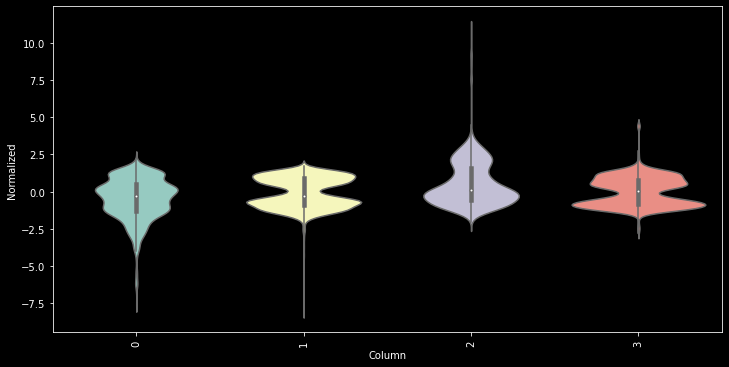

In [6]:
df_std = (fd_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(fd_df.keys(), rotation=90)

## Windowing our Data

Parameters Used:
- time_window : Points within this time delta are considered for windowing
- input_width : Number of datapoints for the input
- label_width : Number of labels forecasted
- shift       : The offset from the input_width to the label width

Now, the Total window size will be `input_width + shift`. This `total_window_size` needs to lie within the `time_window`.

In [11]:
class WindowGenerator():
    
    def __init__(self, time_window, input_width, label_width, shift,
                train_df, val_df, test_df,
                non_label_columns=None):
    
        # Storing the DataFrames
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Label columns (Will Help Generalize the class)
        all_cols = train_df.columns.astype('str').values
        self.label_columns = np.setdiff1d(all_cols, non_label_columns)
        self.label_column_indices = {name: i for i, name in enumerate(self.label_columns)}
        self.column_indices = {name: i for i, name in enumerate(all_cols)}

        # Setup parameters
        self.time_window = pd.Timedelta(time_window)
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    
    def make_dataset(self, data, batch_size=32):
        dataset = []  # Intialize the windowed array
        time_index = []  # to get the timestamps (will help while plotting)

        c = 0  # count the number of discarded data points
        
        for t in data.index:
            time_chunk = data[t: t+self.time_window]  # Get the data chunk in the time_window

            # datapoints in the time window should be atleast the size of the window
            if len(time_chunk) >= self.total_window_size: 
                dataset.append(time_chunk.iloc[0: self.total_window_size].values)  # To have constant windows 

            else:
                c+=1

        print(f'No of data points discarded {c}')
        dataset = tf.convert_to_tensor(dataset)
        
        # Split into inputs and outputs
        inputs = dataset[:, self.input_slice, :]
        labels = dataset[:, self.label_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
        dataset = dataset.batch(batch_size)
        
        del inputs
        del labels
        
        return dataset
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """
        Get and cache an example batch of `inputs, labels` for plotting.
        """
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        
        return result
    
    
    def plot(self, model=None, plot_col='0', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
        
            label_col_index = self.label_column_indices.get(plot_col, None)

            plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

In [12]:
w1 = WindowGenerator(time_window='30H', input_width=10, label_width=1, shift=1,
                    train_df = train_df,
                    val_df = val_df,
                    test_df = test_df)

w1

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['0' '1' '2' '3']

In [13]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

No of data points discarded 547
Inputs shape (batch, time, features): (32, 10, 4)
Labels shape (batch, time, features): (32, 1, 4)


In [16]:
w1.test

No of data points discarded 211


<BatchDataset shapes: ((None, 10, 4), (None, 1, 4)), types: (tf.float64, tf.float64)>

# Single Step Models

In [17]:
## Single Step Model
single_step_window = WindowGenerator(time_window='30H', input_width=10, label_width=1, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df,
                                    non_label_columns=['1', '2', '3'])

single_step_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['0']

In [18]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

No of data points discarded 547
Inputs shape (batch, time, features): (32, 10, 4)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

This Baseline returns the current 0th Fd as the prediction

In [19]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]  ## Understant it

In [22]:
baseline = Baseline(label_index=0)  # index of the column

baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

No of data points discarded 407

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 798us/step - loss: 1.5173 - mean_absolute_error: 0.8465
No of data points discarded 211
5/5 [==============================] - 0s 798us/step - loss: 1.4111 - mean_absolute_error: 0.9269


In [26]:
## Single Step Model
wide_window = WindowGenerator(time_window='30H', input_width=10, label_width=10, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df,
                                    non_label_columns=['1', '2', '3'])

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['0']

In [24]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

No of data points discarded 547
Input shape: (32, 10, 4)
Output shape: (32, 10, 1)


No of data points discarded 547


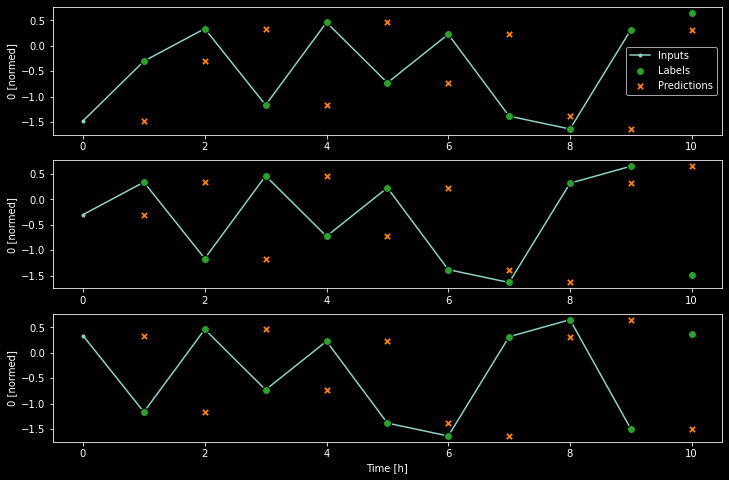

In [27]:
wide_window.plot(baseline)

# Multi-Output

In [55]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

In [32]:
multi_output = WindowGenerator(time_window='30H', input_width=10, label_width=1, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

multi_output

No of data points discarded 547
Inputs shape (batch, time, features): (32, 10, 4)
Labels shape (batch, time, features): (32, 10, 1)


Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['0' '1' '2' '3']

In [33]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

No of data points discarded 407

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 898us/step - loss: 8.3274 - mean_absolute_error: 2.1034
No of data points discarded 211


In [39]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=4)
])

history = compile_and_fit(dense, multi_output)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(multi_output.val)
performance['Dense'] = dense.evaluate(multi_output.test, verbose=0)

No of data points discarded 407
10/10 [==============================] - 0s 2ms/step - loss: 2.6998 - mean_absolute_error: 1.1934
No of data points discarded 211


In [56]:
%%time
tf.keras.backend.clear_session()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(200, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(80),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=4)
])

history = compile_and_fit(lstm_model, multi_output)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( multi_output.val)
performance['LSTM'] = lstm_model.evaluate( multi_output.test, verbose=0)

print()

No of data points discarded 407
10/10 [==============================] - 0s 16ms/step - loss: 3.1019 - mean_absolute_error: 1.2324
No of data points discarded 211

Wall time: 2min 52s


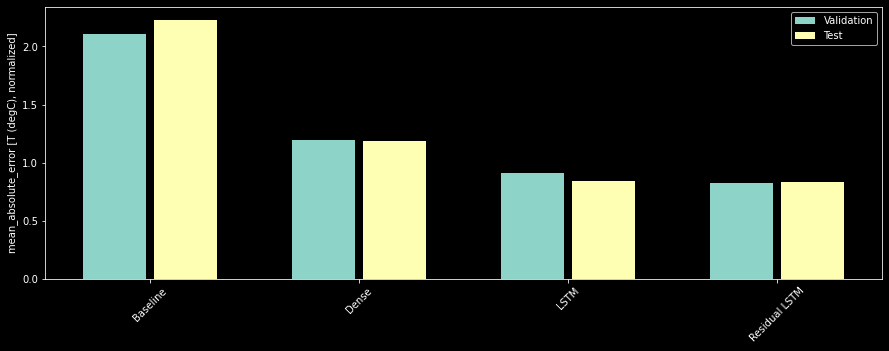

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [46]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [48]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        4,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, multi_output)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_output.val)
performance['Residual LSTM'] = residual_lstm.evaluate(multi_output.test, verbose=0)
print()

No of data points discarded 407
10/10 [==============================] - 0s 4ms/step - loss: 1.4603 - mean_absolute_error: 0.8212
No of data points discarded 211

Wall time: 14.4 s


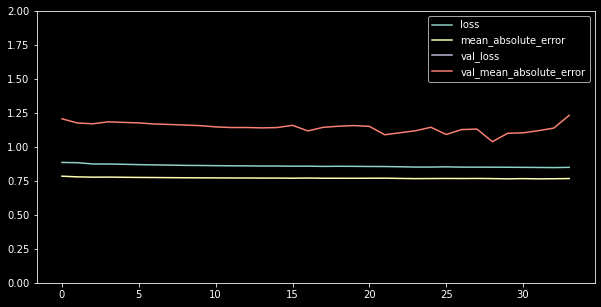

In [57]:
pd.DataFrame(history.history).plot(figsize=(10,5))
# plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

## Understanding

In [256]:
time_window = '30H'
input_width = 10
label_width = 1
shift = 1

total_window_size = input_width + shift  # total window size
label_start = total_window_size - label_width  # Label Start index
time_window = pd.Timedelta(time_window)

In [257]:
input_slice = slice(0, input_width)
label_slice = slice(label_start, None)

In [261]:
# Getting full windows as a numpy array
# will be a 3d array
# (batch, timestep, features)

td = val_df.copy()
td.shape

(724, 4)

In [259]:

total_window_size

t1 = np.array([1,2,3])
t2 = np.array([4,5,6])

# tf.concat([t1,t2], axis=1)

tf.stack([t1,t2])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [260]:
custom_window = []  # Intialize the windowed array
time_index = []  # to get the timestamps (will help while plotting)

c = 0  # count the number of discarded data points

for t in td.index:
    time_chunk = td[t: t+time_window]  # Get the data chunk in the time_window
    
    # datapoints in the time window should be atleast the size of the window
    if len(time_chunk) >= total_window_size: 
        custom_window.append(time_chunk.iloc[0:total_window_size].values)  # To have constant windows 
    
    else:
        c+=1
        
print(f'No of data points discarded {c}')
custom_window = tf.convert_to_tensor(custom_window)

No of data points discarded 407


In [262]:
# Splitting

inputs = custom_window[:, input_slice, :]
labels = custom_window[:, label_slice, :]


# Create a mapping to keep only those indixes from the labels we need

inputs.set_shape([None, input_width, None])
labels.set_shape([None, label_width, None])

In [263]:
ds =tf.data.Dataset.from_tensor_slices((inputs, labels))

In [264]:
ds

<TensorSliceDataset shapes: ((10, 4), (1, 4)), types: (tf.float64, tf.float64)>

In [208]:
batch_size = 32
shuffle_buffer_size = 500

ds = ds.shuffle(shuffle_buffer_size).batch(batch_size)

In [210]:
for example_inputs, example_labels in ds.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 4)
Labels shape (batch, time, features): (32, 1, 4)


In [159]:
tf.data.Dataset.from_tensor_slices()

<TensorSliceDataset shapes: (11, 4), types: tf.float64>

In [157]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
  data=twin,
  targets=None,
  sequence_length=total_window_size,
  sequence_stride=1,
  shuffle=True,
  batch_size=32,)

AttributeError: module 'tensorflow.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'

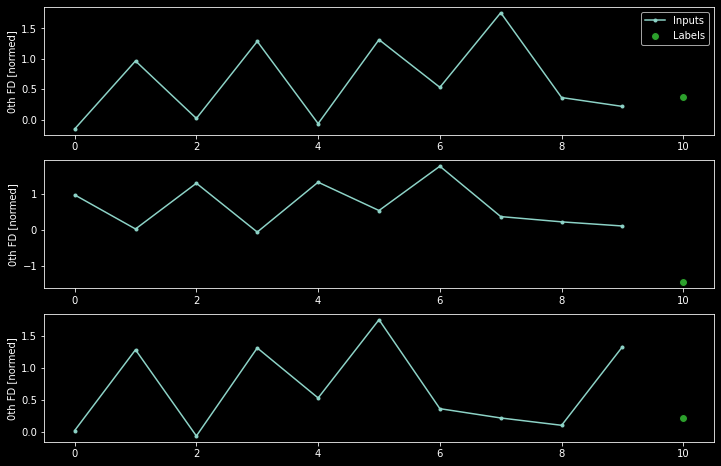

In [92]:
plot_index = 2 # Oth fd

input_indices = np.arange(total_window_size)[input_slice]
label_indices = np.arange(total_window_size)[label_slice]

max_subplots=3
plt.figure(figsize=(12, 8))
plot_col_index = plot_index
max_n = min(max_subplots, len(inputs))

for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel('0th FD [normed]')
    plt.plot(input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.',
            zorder=-10)
    
    label_col_index = 0
    
    plt.scatter(label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels',
               c='#2ca02c', s=64)
    
    if n == 0:
        plt.legend()

In [125]:
tf.data.Dataset.from_tensors(inputs)

<TensorDataset shapes: (10, 10, 4), types: tf.float64>